## Chapter 23 - Ordinal Predicted Variable

- [23.2 - The Case of a Single Group](#23.2---The-Case-of-a-Single-Group)
- [23.3 - The Case of Two Groups](#23.3---The-Case-of-Two-Groups)
- [23.4 - The Case of Metric Predictors](#23.4---The-Case-of-Metric-Predictors)
 - [One Predictor](#One-Predictor)
 - [Two Predictors](#Two-Predictors)

In [1]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

from theano.compile.ops import as_op
from scipy.stats import mode, norm
from matplotlib import gridspec
from IPython.display import Image

pd.set_option('display.notebook_repr_html', False)

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':14}

### 23.2 - The Case of a Single Group
Code based on https://gist.github.com/DanielWeitzenfeld/d9ac64f76281e6c1d29217af76449664

#### Data

In [2]:
# Using dtype 'category' for Y
df = pd.read_csv('data/OrdinalProbitData-1grp-1.csv', dtype={'Y':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
Y    100 non-null category
dtypes: category(1)
memory usage: 236.0 bytes


In [3]:
df.Y.value_counts(sort=False)

1    58
2    15
3    12
4     8
5     4
6     2
7     1
Name: Y, dtype: int64

In [4]:
# Number of outcomes
nYlevels = df.Y.cat.categories.size

thresh = [k + .5 for k in range(1, nYlevels)]
thresh_obs = np.ma.asarray(thresh)
thresh_obs[1:-1] = np.ma.masked

print('thresh:\t\t{}'.format(thresh))
print('thresh_obs:\t{}'.format(thresh_obs))

thresh:		[1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
thresh_obs:	[1.5 -- -- -- -- 6.5]


#### Model

In [5]:
# Using the Theano @as_op decorator with a custom function to calculate the threshold probabilities.
# Theano cannot compute a gradient for these custom functions, so it is not possible to use
# gradient based samplers in PyMC3.
# http://pymc-devs.github.io/pymc3/notebooks/getting_started.html#Arbitrary-deterministics
@as_op(itypes=[tt.dvector, tt.dscalar, tt.dscalar], otypes=[tt.dvector])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty(nYlevels)
    n = norm(loc=mu, scale=sigma)       
    out[0] = n.cdf(theta[0])        
    out[1] = np.max([0, n.cdf(theta[1]) - n.cdf(theta[0])])
    out[2] = np.max([0, n.cdf(theta[2]) - n.cdf(theta[1])])
    out[3] = np.max([0, n.cdf(theta[3]) - n.cdf(theta[2])])
    out[4] = np.max([0, n.cdf(theta[4]) - n.cdf(theta[3])])
    out[5] = np.max([0, n.cdf(theta[5]) - n.cdf(theta[4])])
    out[6] = 1 - n.cdf(theta[5])
    return out

with pm.Model() as ordinal_model_single:    
    
    theta = pm.Normal('theta', mu=thresh, tau=np.repeat(.5**2, len(thresh)),
                      shape=len(thresh), observed=thresh_obs, testval=thresh[1:-1])
    
    mu = pm.Normal('mu', mu=nYlevels/2.0, tau=1.0/(nYlevels**2))
    sigma = pm.Uniform('sigma', nYlevels/1000.0, nYlevels*10.0)
    
    pr = outcome_probabilities(theta, mu, sigma)
    
    y = pm.Categorical('y', pr, observed=df.Y.cat.codes.as_matrix())

Applied interval-transform to sigma and added transformed sigma_interval_ to model.


In [6]:
with ordinal_model_single:
    step = pm.Metropolis([theta, mu, sigma, pr, y])
    trace1 = pm.sample(10000, step=step)

 [-----------------100%-----------------] 10000 of 10000 complete in 127.8 sec

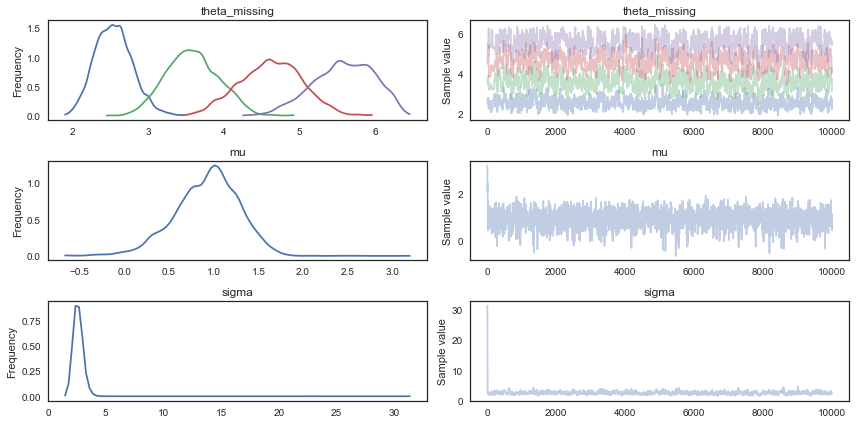

In [7]:
pm.traceplot(trace1);

#### Figure 23.2

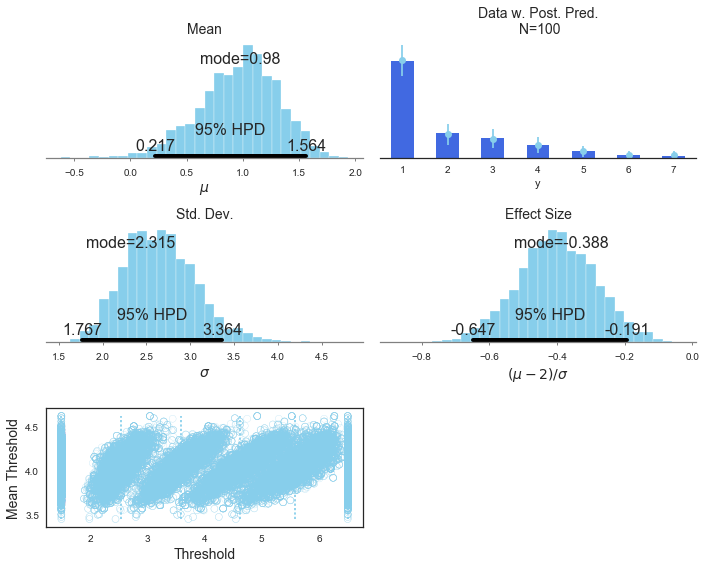

In [8]:
burnin=100

mu = trace1['mu'][burnin:]
sigma = trace1['sigma'][burnin:]

# Concatenate the fixed thresholds into the estimated thresholds
n = trace1['theta_missing'].shape[0]
thresholds = np.c_[np.tile([1.5], (n,1)),
                   trace1['theta_missing'],
                   np.tile([6.5], (n,1))][burnin:]

# Define gridspec
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])
ax5 = plt.subplot(gs[2,0])

# Mu
pm.plot_posterior(mu, point_estimate='mode', color=color, ax=ax1)
ax1.set_title('Mean', fontdict=f_dict)
ax1.set_xlabel('$\mu$', fontdict=f_dict)

# Posterior predictive probabilities of the outcomes
threshCumProb = np.empty(thresholds.shape)
for i in np.arange(threshCumProb.shape[0]):
    threshCumProb[i] = norm().cdf((thresholds[i] - mu[i])/sigma[i])    
outProb = (np.c_[threshCumProb, np.tile(1, (thresholds.shape[0],1))]
           - np.c_[np.tile(0, (thresholds.shape[0],1)), threshCumProb])
yerr = np.abs(np.subtract(pm.hpd(outProb), outProb.mean(axis=0).reshape(-1,1)))

(df.Y.value_counts()/df.Y.size).plot.bar(ax=ax2, rot=0, color='royalblue')
ax2.errorbar(x = np.arange(df.Y.nunique()), y=outProb.mean(axis=0),
             yerr=yerr.T, color=color, fmt='o')
ax2.set_xlabel('y')
sns.despine(ax=ax2, left=True)
ax2.yaxis.set_visible(False)
ax2.set_title('Data w. Post. Pred.\n N={}'.format(df.Y.size), fontdict=f_dict)

# Sigma
pm.plot_posterior(sigma, point_estimate='mode', color=color, ax=ax3)
ax3.set_title('Std. Dev.', fontdict=f_dict)
ax3.set_xlabel('$\sigma$', fontdict=f_dict)

# Effect size
pm.plot_posterior((mu-2)/sigma,point_estimate='mode',  color=color, ax=ax4)
ax4.set_title('Effect Size', fontdict=f_dict)
ax4.set_xlabel('$(\mu-2)/\sigma$', fontdict=f_dict)

# Posterior distribution on the thresholds
ax5.scatter(thresholds, np.tile(thresholds.mean(axis=1).reshape(-1,1), (1,6)), color=color, alpha=.6, facecolor='none')
ax5.set_ylabel('Mean Threshold', fontdict=f_dict)
ax5.set_xlabel('Threshold', fontdict=f_dict)
ax5.vlines(x = thresholds.mean(axis=0),
           ymin=thresholds.mean(axis=1).min(),
           ymax=thresholds.mean(axis=1).max(), linestyles='dotted', colors=color)

fig.tight_layout()

### 23.3 - The Case of Two Groups

#### Data

In [9]:
# Using dtype 'category' for X & Y
df2 = pd.read_csv('data/OrdinalProbitData1.csv', dtype={'X':'category','Y':'category'})
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 2 columns):
X    88 non-null category
Y    88 non-null category
dtypes: category(2)
memory usage: 312.0 bytes


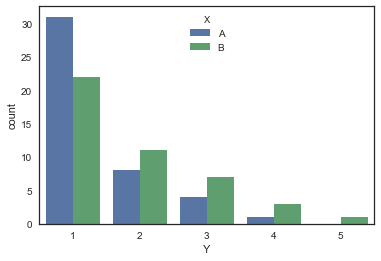

In [10]:
sns.countplot(x=df2.Y, hue=df2.X);

In [11]:
# Number of outcomes
nYlevels2 = df2.Y.cat.categories.size
# Number of groups
n_grps = df2.X.nunique()
# Group index
grp_idx = df2.X.cat.codes.as_matrix()

thresh2 = [k + .5 for k in range(1, nYlevels2)]
thresh_obs2 = np.ma.asarray(thresh2)
thresh_obs2[1:-1] = np.ma.masked

print('thresh2:\t{}'.format(thresh2))
print('thresh_obs2:\t{}'.format(thresh_obs2))

thresh2:	[1.5, 2.5, 3.5, 4.5]
thresh_obs2:	[1.5 -- -- 4.5]


#### Model

In [12]:
@as_op(itypes=[tt.dvector, tt.dvector, tt.dvector], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((nYlevels2, n_grps))
    n = norm(loc=mu, scale=sigma)       
    out[0,:] = n.cdf(theta[0])        
    out[1,:] = np.max([[0,0], n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[2,:] = np.max([[0,0], n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[3,:] = np.max([[0,0], n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[4,:] = 1 - n.cdf(theta[3])
    return out

with pm.Model() as ordinal_model_multi_groups:    
    
    theta = pm.Normal('theta', mu=thresh2, tau=np.repeat(.5**2, len(thresh2)),
                      shape=len(thresh2), observed=thresh_obs2, testval=thresh2[1:-1])
    
    mu = pm.Normal('mu', mu=nYlevels2/2.0, tau=1.0/(nYlevels2**2), shape=n_grps)
    sigma = pm.Uniform('sigma', nYlevels2/1000.0, nYlevels2*10.0, shape=n_grps)
    
    pr = outcome_probabilities(theta, mu, sigma)
    
    y = pm.Categorical('y', pr[:,grp_idx].T, observed=df2.Y.cat.codes.as_matrix())

Applied interval-transform to sigma and added transformed sigma_interval_ to model.


In [13]:
with ordinal_model_multi_groups:
    step = pm.Metropolis([theta, mu, sigma, pr, y])
    trace2 = pm.sample(10000, step=step)

 [-----------------100%-----------------] 10000 of 10000 complete in 105.9 sec

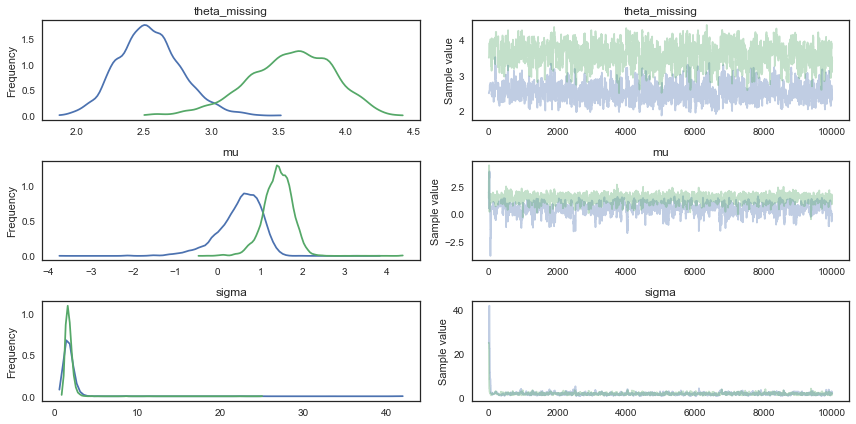

In [14]:
pm.traceplot(trace2);

#### Figure 23.4

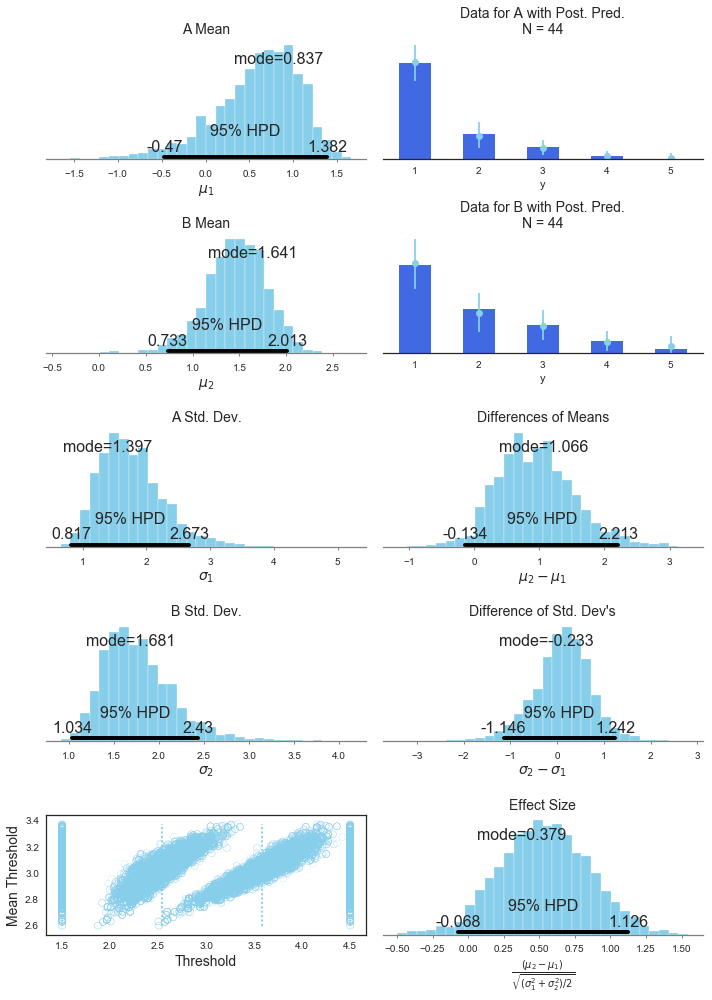

In [15]:
burnin=250

mu2 = trace2['mu'][burnin:]
sigma2 = trace2['sigma'][burnin:]

# Concatenate the fixed thresholds into the estimated thresholds
n = trace2['theta_missing'].shape[0]
thresholds2 = np.c_[np.tile([1.5], (n,1)),
                    trace2['theta_missing'],
                    np.tile([4.5], (n,1))][burnin:]

fig, axes = plt.subplots(5,2, figsize=(10,14))
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10 = axes.flatten() 

# Mu
pm.plot_posterior(mu2[:,0], point_estimate='mode', color=color, ax=ax1)
ax1.set_xlabel('$\mu_{1}$', fontdict=f_dict)
pm.plot_posterior(mu2[:,1], point_estimate='mode', color=color, ax=ax3)
ax3.set_xlabel('$\mu_{2}$', fontdict=f_dict)
for title, ax in zip(['A Mean', 'B Mean'], [ax1, ax3]):
    ax.set_title(title, fontdict=f_dict)

# Sigma
pm.plot_posterior(sigma2[:,0], point_estimate='mode', color=color, ax=ax5)
ax5.set_xlabel('$\sigma_{1}$', fontdict=f_dict)
pm.plot_posterior(sigma2[:,1], point_estimate='mode', color=color, ax=ax7)
ax7.set_xlabel('$\sigma_{2}$', fontdict=f_dict)
for title, ax in zip(['A Std. Dev.', 'B Std. Dev.'], [ax5, ax7]):
    ax.set_title(title, fontdict=f_dict)

# Posterior distribution on the thresholds
ax9.scatter(thresholds2, np.tile(thresholds2.mean(axis=1).reshape(-1,1), (1,4)), color=color, alpha=.6, facecolor='none')
ax9.set_ylabel('Mean Threshold', fontdict=f_dict)
ax9.set_xlabel('Threshold', fontdict=f_dict)
ax9.vlines(x = thresholds2.mean(axis=0),
           ymin=thresholds2.mean(axis=1).min(),
           ymax=thresholds2.mean(axis=1).max(), linestyles='dotted', colors=color)

# Posterior predictive probabilities of the outcomes
threshCumProb2A = np.empty(thresholds2.shape)
for i in np.arange(threshCumProb2A.shape[0]):
    threshCumProb2A[i] = norm().cdf((thresholds2[i] - mu2[i,0])/sigma2[i,0])    
outProb2A = (np.c_[threshCumProb2A, np.tile(1, (thresholds2.shape[0],1))]
           - np.c_[np.tile(0, (thresholds2.shape[0],1)), threshCumProb2A])
yerr2A = np.abs(np.subtract(pm.hpd(outProb2A), outProb2A.mean(axis=0).reshape(-1,1)))

ax2.errorbar(x = np.arange(outProb2A.shape[1]), y=outProb2A.mean(axis=0),
             yerr=yerr2A.T, color=color, fmt='o')

threshCumProb2B = np.empty(thresholds2.shape)
for i in np.arange(threshCumProb2B.shape[0]):
    threshCumProb2B[i] = norm().cdf((thresholds2[i] - mu2[i,1])/sigma2[i,1])    
outProb2B = (np.c_[threshCumProb2B, np.tile(1, (thresholds2.shape[0],1))]
           - np.c_[np.tile(0, (thresholds2.shape[0],1)), threshCumProb2B])
yerr2B = np.abs(np.subtract(pm.hpd(outProb2B), outProb2B.mean(axis=0).reshape(-1,1)))

ax4.errorbar(x = np.arange(outProb2B.shape[1]), y=outProb2B.mean(axis=0),
             yerr=yerr2B.T, color=color, fmt='o')

for grp, ax in zip(['A', 'B'], [ax2, ax4]):
    ((df2[df2.X == grp].Y.value_counts()/df2[df2.X == grp].Y.size)
     .plot.bar(ax=ax, rot=0, color='royalblue'))
    ax.set_title('Data for {0} with Post. Pred.\nN = {1}'.format(grp, df2[df2.X == grp].Y.size), fontdict=f_dict)
    ax.set_xlabel('y')
    sns.despine(ax=ax, left=True)
    ax.yaxis.set_visible(False)

# Mu diff
pm.plot_posterior(mu2[:,1]-mu2[:,0], point_estimate='mode', color=color, ax=ax6)
ax6.set_xlabel('$\mu_{2}-\mu_{1}$', fontdict=f_dict)
# Sigma diff
pm.plot_posterior(sigma2[:,1]-sigma2[:,0], point_estimate='mode', color=color, ax=ax8)
ax8.set_xlabel('$\sigma_{2}-\sigma_{1}$', fontdict=f_dict)
# Effect size
pm.plot_posterior((mu2[:,1]-mu2[:,0]) / np.sqrt((sigma2[:,0]**2+sigma2[:,1]**2)/2), point_estimate='mode', color=color, ax=ax10)
ax10.set_xlabel(r'$\frac{(\mu_2-\mu_1)}{\sqrt{(\sigma_1^2+\sigma_2^2)/2}}$', fontdict=f_dict)
for title, ax in zip(['Differences of Means', 'Difference of Std. Dev\'s', 'Effect Size'], [ax6, ax8, ax10]):
    ax.set_title(title, fontdict=f_dict)

fig.tight_layout()

### 23.4 - The Case of Metric Predictors
#### One Predictor

#### Data

In [16]:
df3 = pd.read_csv('data/OrdinalProbitData-LinReg-2.csv', dtype={'Y':'category'})
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
X    200 non-null float64
Y    200 non-null category
dtypes: category(1), float64(1)
memory usage: 1.9 KB


In [17]:
df3.head()

          X  Y
0  1.386389  1
1  1.223879  1
2  1.454505  5
3  1.112068  5
4  1.222715  1

#### Standardize data

In [18]:
sd_X = df3.X.std()
mean_X = df3.X.mean()
zX = (df3.X - mean_X)/sd_X

In [19]:
nYlevels3 = df3.Y.nunique()

thresh3 = [k + .5 for k in range(1, nYlevels3)]
thresh_obs3 = np.ma.asarray(thresh3)
thresh_obs3[1:-1] = np.ma.masked

print('thresh3:\t{}'.format(thresh3))
print('thresh_obs3:\t{}'.format(thresh_obs3))

thresh3:	[1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
thresh_obs3:	[1.5 -- -- -- -- 6.5]


#### Model
Not generalized for multiple metric predictors.

In [20]:
@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((mu.size, nYlevels3))
    n = norm(loc=mu, scale=sigma)       
    out[:,0] = n.cdf(theta[0])        
    out[:,1] = np.max([np.repeat(0,mu.size), n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[:,2] = np.max([np.repeat(0,mu.size), n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[:,3] = np.max([np.repeat(0,mu.size), n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[:,4] = np.max([np.repeat(0,mu.size), n.cdf(theta[4]) - n.cdf(theta[3])], axis=0)
    out[:,5] = np.max([np.repeat(0,mu.size), n.cdf(theta[5]) - n.cdf(theta[4])], axis=0)
    out[:,6] = 1 - n.cdf(theta[5])
    return out

with pm.Model() as ordinal_model_metric:    
    
    theta = pm.Normal('theta', mu=thresh3, tau=np.repeat(1/2**2, len(thresh3)),
                      shape=len(thresh3), observed=thresh_obs3, testval=thresh3[1:-1])
    
    zbeta0 = pm.Normal('zbeta0', mu=(1+nYlevels3)/2, tau=1/nYlevels3**2)
    zbeta = pm.Normal('zbeta', mu=0.0, tau=1/nYlevels3**2)
    mu = pm.Deterministic('mu', zbeta0 + zbeta*zX)
        
    zsigma = pm.Uniform('zsigma', nYlevels3/1000.0, nYlevels3*10.0)
            
    pr = outcome_probabilities(theta, mu, zsigma)
    
    y = pm.Categorical('y', pr, observed=df3.Y.cat.codes)

Applied interval-transform to zsigma and added transformed zsigma_interval_ to model.


In [21]:
with ordinal_model_metric:
    step1 = pm.Metropolis(vars=[pr, y, zbeta0, zbeta, zsigma])
    trace3 = pm.sample(10000, step=step1)

 [-----------------100%-----------------] 10000 of 10000 complete in 200.3 sec

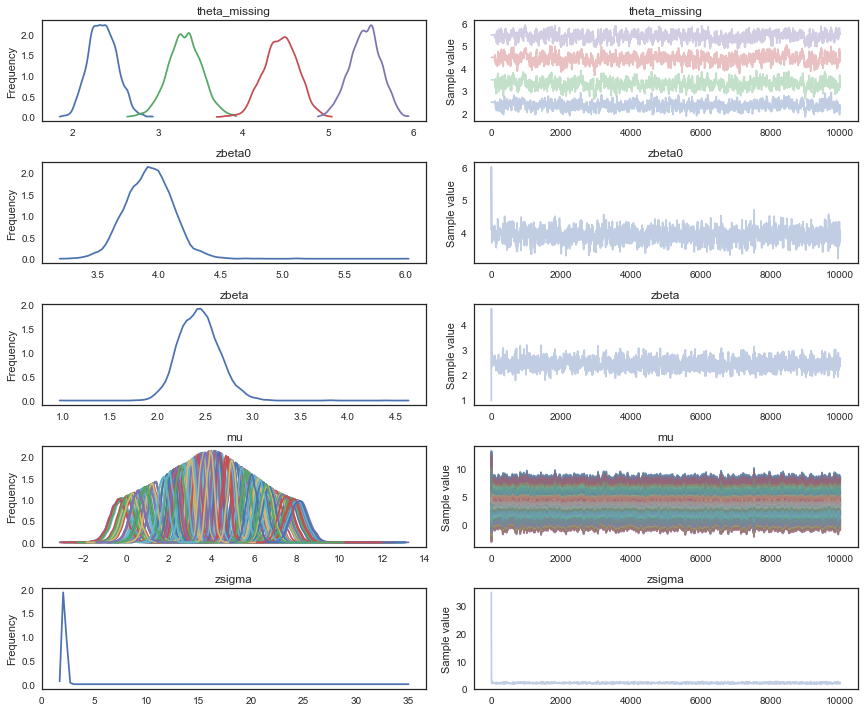

In [22]:
pm.traceplot(trace3);

#### Figure 23.7

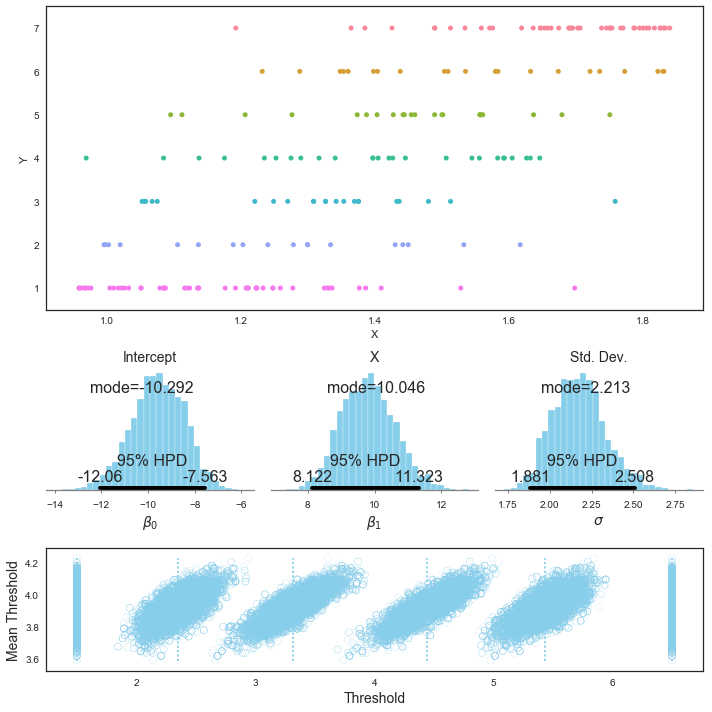

In [23]:
burnin = 400
# Convert parameters to original scale
beta = trace3['zbeta'][burnin:]/sd_X
beta0 = trace3['zbeta0'][burnin:] - trace3['zbeta'][burnin:]*mean_X/sd_X
sigma = trace3['zsigma'][burnin:]

# Concatenate the fixed thresholds into the estimated thresholds
n = trace3['theta_missing'].shape[0]
thresholds3 = np.c_[np.tile([1.5], (n,1)),
                   trace3['theta_missing'],
                   np.tile([6.5], (n,1))][burnin:]

# Define gridspec
fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(4, 3)
ax1 = plt.subplot(gs[:2,:])
ax2 = plt.subplot(gs[2,0])
ax3 = plt.subplot(gs[2,1])
ax4 = plt.subplot(gs[2,2])
ax5 = plt.subplot(gs[3,:])

sns.stripplot('X', 'Y', data=df3, order=df3.Y.cat.categories[::-1], ax=ax1)

pm.plot_posterior(beta0, point_estimate='mode', color=color, ax=ax2)
pm.plot_posterior(beta, point_estimate='mode', color=color, ax=ax3)
pm.plot_posterior(sigma, point_estimate='mode', color=color, ax=ax4);
for title, label, ax in zip(['Intercept', 'X', 'Std. Dev.'],
                            [r'$\beta_{0}$', r'$\beta_{1}$', r'$\sigma$'],
                            [ax2, ax3, ax4]):
    ax.set_title(title, fontdict=f_dict)
    ax.set_xlabel(label, fontdict=f_dict)
    
# Posterior distribution on the thresholds
ax5.scatter(thresholds3, np.tile(thresholds3.mean(axis=1).reshape(-1,1), (1,6)), color=color, alpha=.6, facecolor='none')
ax5.set_ylabel('Mean Threshold', fontdict=f_dict)
ax5.set_xlabel('Threshold', fontdict=f_dict)
ax5.vlines(x = thresholds3.mean(axis=0),
           ymin=thresholds3.mean(axis=1).min(),
           ymax=thresholds3.mean(axis=1).max(), linestyles='dotted', colors=color)
    
fig.tight_layout()

#### Two Predictors

#### Data

In [102]:
df4 = pd.read_csv('data/Movies.csv', usecols=[1,2,4], dtype={'Rating':'category'})
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
Year      100 non-null int64
Length    100 non-null int64
Rating    100 non-null category
dtypes: category(1), int64(2)
memory usage: 1.8 KB


In [103]:
df4.head()

   Year  Length Rating
0  1963      89      2
1  1943     127      3
2  1984     138      3
3  1978      97      3
4  1931      77    2.5

In [34]:
X = df4[['Year','Length']]
Y = df4.Rating

In [36]:
sd_X = X.std()
mean_X = X.mean()
zX = (X - mean_X)/sd_X

In [37]:
nYlevels4 = Y.nunique()

thresh4 = [k + .5 for k in range(1, nYlevels4)]
thresh_obs4 = np.ma.asarray(thresh4)
thresh_obs4[1:-1] = np.ma.masked

print('thresh4:\t{}'.format(thresh4))
print('thresh_obs4:\t{}'.format(thresh_obs4))

thresh4:	[1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
thresh_obs4:	[1.5 -- -- -- -- 6.5]


In [53]:
@as_op(itypes=[tt.dvector, tt.dvector, tt.dscalar], otypes=[tt.dmatrix])
def outcome_probabilities(theta, mu, sigma):
    out = np.empty((mu.size, nYlevels4))
    n = norm(loc=mu, scale=sigma)       
    out[:,0] = n.cdf(theta[0])        
    out[:,1] = np.max([np.repeat(0,mu.size), n.cdf(theta[1]) - n.cdf(theta[0])], axis=0)
    out[:,2] = np.max([np.repeat(0,mu.size), n.cdf(theta[2]) - n.cdf(theta[1])], axis=0)
    out[:,3] = np.max([np.repeat(0,mu.size), n.cdf(theta[3]) - n.cdf(theta[2])], axis=0)
    out[:,4] = np.max([np.repeat(0,mu.size), n.cdf(theta[4]) - n.cdf(theta[3])], axis=0)
    out[:,5] = np.max([np.repeat(0,mu.size), n.cdf(theta[5]) - n.cdf(theta[4])], axis=0)
    out[:,6] = 1 - n.cdf(theta[5])
    return out

with pm.Model() as ordinal_model_multi_metric:    
    
    theta = pm.Normal('theta', mu=thresh4, tau=np.repeat(1/2**2, len(thresh4)),
                      shape=len(thresh4), observed=thresh_obs4, testval=thresh4[1:-1])
    
    zbeta0 = pm.Normal('zbeta0', mu=(1+nYlevels4)/2, tau=1/nYlevels4**2)
    zbeta = pm.Normal('zbeta', mu=0.0, tau=1/nYlevels4**2, shape=X.shape[1])
    mu = pm.Deterministic('mu', zbeta0 + pm.dot(zbeta,zX.T))
        
    zsigma = pm.Uniform('zsigma', nYlevels4/1000.0, nYlevels4*10.0)
            
    pr = outcome_probabilities(theta, mu, zsigma)
    
    y = pm.Categorical('y', pr, observed=Y.cat.codes)

Applied interval-transform to zsigma and added transformed zsigma_interval_ to model.


In [54]:
with ordinal_model_multi_metric:
    step1 = pm.Metropolis(vars=[pr, y, zbeta0, zbeta, zsigma])
    trace4 = pm.sample(10000, step=step1)

 [-----------------100%-----------------] 10000 of 10000 complete in 189.9 sec

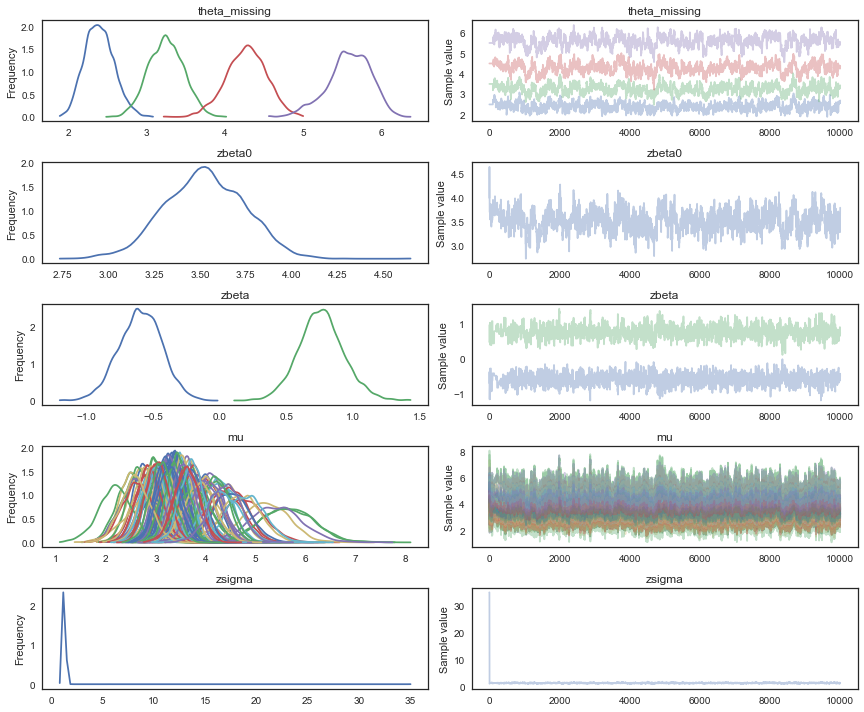

In [55]:
pm.traceplot(trace4);

#### Figure 23.9

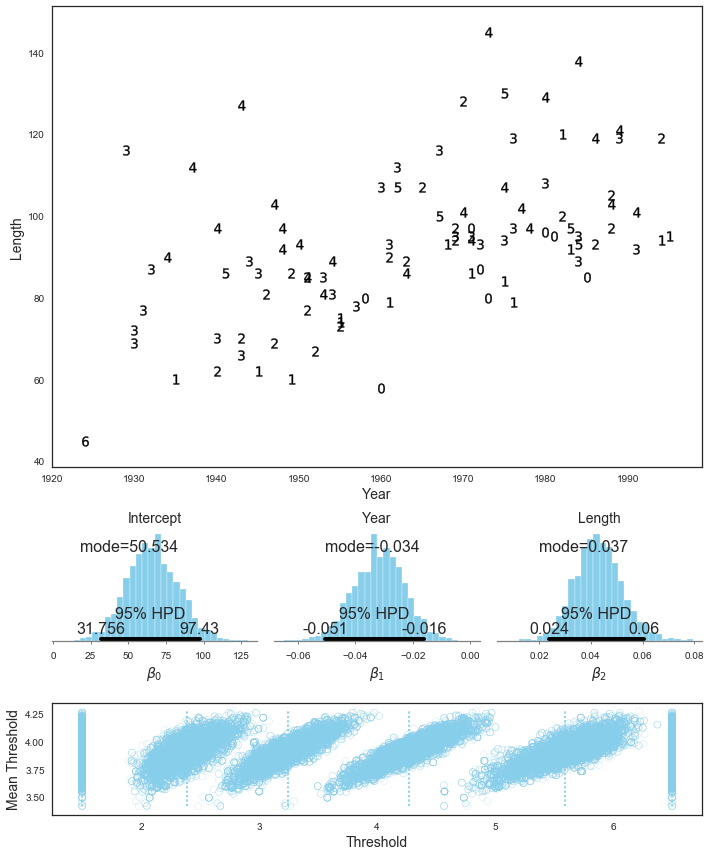

In [110]:
burnin = 400
# Convert parameters to original scale
beta = trace4['zbeta'][burnin:]/sd_X.as_matrix()
beta0 = trace4['zbeta0'][burnin:] - np.sum(trace4['zbeta'][burnin:]*mean_X.as_matrix()/sd_X.as_matrix(), axis=1)
sigma = trace4['zsigma'][burnin:]

# Concatenate the fixed thresholds into the estimated thresholds
n = trace4['theta_missing'].shape[0]
thresholds4 = np.c_[np.tile([1.5], (n,1)),
                   trace4['theta_missing'],
                   np.tile([6.5], (n,1))][burnin:]

# Define gridspec
fig = plt.figure(figsize=(10,12))
gs = gridspec.GridSpec(5, 3)
ax1 = plt.subplot(gs[:3,:])
ax2 = plt.subplot(gs[3,0])
ax3 = plt.subplot(gs[3,1])
ax4 = plt.subplot(gs[3,2])
ax5 = plt.subplot(gs[4,:])

for year, length, marker in zip(df4.Year, df4.Length, df4.Rating.cat.codes.map(lambda m: r'${}$'.format(m))):
    ax1.scatter(year, length, marker=marker, s=100, c='k')
ax1.set_xlabel('Year', fontdict=f_dict)
ax1.set_ylabel('Length', fontdict=f_dict)
    
pm.plot_posterior(beta0, point_estimate='mode', color=color, ax=ax2)
pm.plot_posterior(beta[:,0], point_estimate='mode', color=color, ax=ax3)
pm.plot_posterior(beta[:,1], point_estimate='mode', color=color, ax=ax4);
for title, label, ax in zip(['Intercept', 'Year', 'Length'],
                            [r'$\beta_{0}$', r'$\beta_{1}$', r'$\beta_{2}$'],
                            [ax2, ax3, ax4]):
    ax.set_title(title, fontdict=f_dict)
    ax.set_xlabel(label, fontdict=f_dict)
    
# Posterior distribution on the thresholds
ax5.scatter(thresholds4, np.tile(thresholds4.mean(axis=1).reshape(-1,1), (1,6)), color=color, alpha=.6, facecolor='none')
ax5.set_ylabel('Mean Threshold', fontdict=f_dict)
ax5.set_xlabel('Threshold', fontdict=f_dict)
ax5.vlines(x = thresholds4.mean(axis=0),
           ymin=thresholds4.mean(axis=1).min(),
           ymax=thresholds4.mean(axis=1).max(), linestyles='dotted', colors=color)
    
fig.tight_layout()